In [4]:
# Title: Setup
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 160

# Robustly locate repo root (expects 'results/reports' folder to exist)
def find_repo_root(start=Path.cwd()):
    p = start.resolve()
    for _ in range(6):
        if (p / "results" / "reports").exists():
            return p
        p = p.parent
    raise FileNotFoundError("Could not find repo root with results/reports present.")

PROJECT = find_repo_root()
REPORTS = PROJECT / "results" / "reports"
DOCKING = PROJECT / "results" / "docking"

# Inputs produced in your run
ranking_csv = REPORTS / "ranking_table.csv"      # includes: ligand, affinity_kcal_mol, MW, PSA, cLogP, BBB_pass, composite_score
docking_csv = PROJECT / "results" / "docking" / "docking_results.csv"  # ligand, affinity_kcal_mol, pose_path

df_rank = pd.read_csv(ranking_csv)
df_dock = pd.read_csv(docking_csv)

# Basic cleaning/types
num_cols = ["affinity_kcal_mol","MW","PSA","cLogP","composite_score"]
for c in num_cols:
    if c in df_rank.columns:
        df_rank[c] = pd.to_numeric(df_rank[c], errors="coerce")

# Sort by composite (desc) then affinity (asc/ more negative is better)
df_ranked = df_rank.sort_values(["composite_score","affinity_kcal_mol"], ascending=[False, True]).reset_index(drop=True)

df_ranked.head(3)


,ligand,pose_path,log_path,retcode,affinity_kcal_mol,parsed_from,MW,PSA,cLogP,BBB_pass,composite_score
0,donepezil,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-8.2,log_table,392.209993,42.01,3.85640,True,2.247032
1,galantamine,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-7.6,log_table,278.094294,39.44,4.24490,True,1.516411
2,nilvadipine,C:\Users\ashak\ad-quantum-repurpose\results\do...,C:\Users\ashak\ad-quantum-repurpose\results\do...,0,-7.0,log_table,433.048378,78.51,4.46442,True,0.785789


WindowsPath('C:/Users/ashak/ad-quantum-repurpose/results/reports/fig1_docking_bar.png')

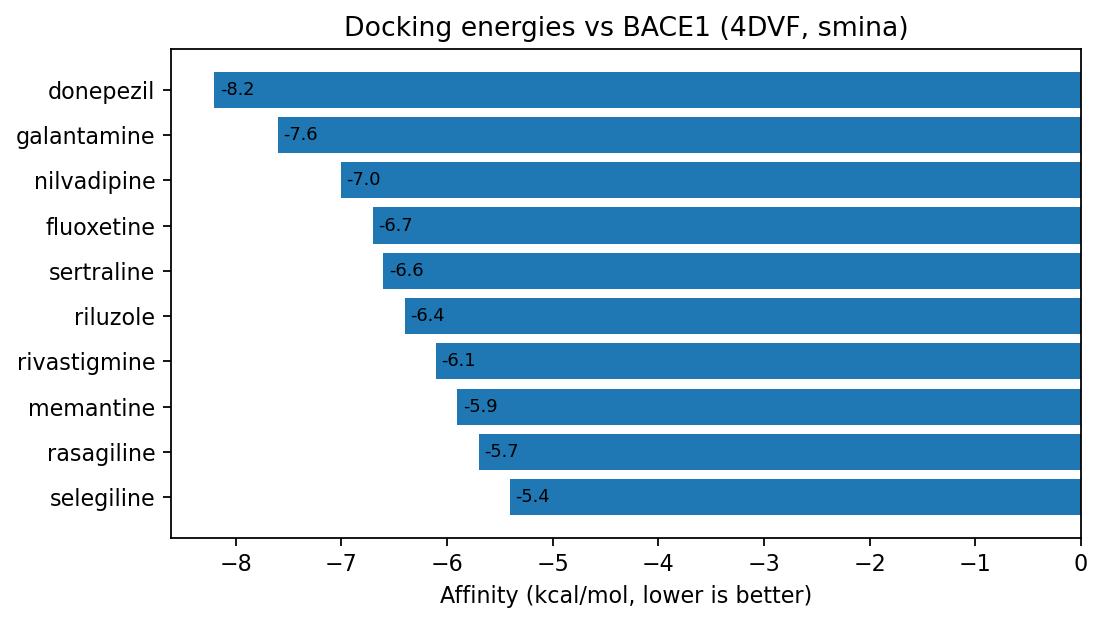

In [5]:
# Title: Figure 1 - Docking bar plot
df_plot = df_dock.copy()
df_plot = df_plot.sort_values("affinity_kcal_mol")  # ascending (most negative first)

fig, ax = plt.subplots(figsize=(7,4))
ax.barh(df_plot["ligand"], df_plot["affinity_kcal_mol"])
ax.invert_yaxis()
ax.set_xlabel("Affinity (kcal/mol, lower is better)")
ax.set_title("Docking energies vs BACE1 (4DVF, smina)")
for i, v in enumerate(df_plot["affinity_kcal_mol"]):
    ax.text(v + 0.05, i, f"{v:.1f}", va="center", fontsize=8)
out = REPORTS / "fig1_docking_bar.png"
plt.tight_layout()
plt.savefig(out, bbox_inches="tight")
out


WindowsPath('C:/Users/ashak/ad-quantum-repurpose/results/reports/fig2_composite_vs_mw.png')

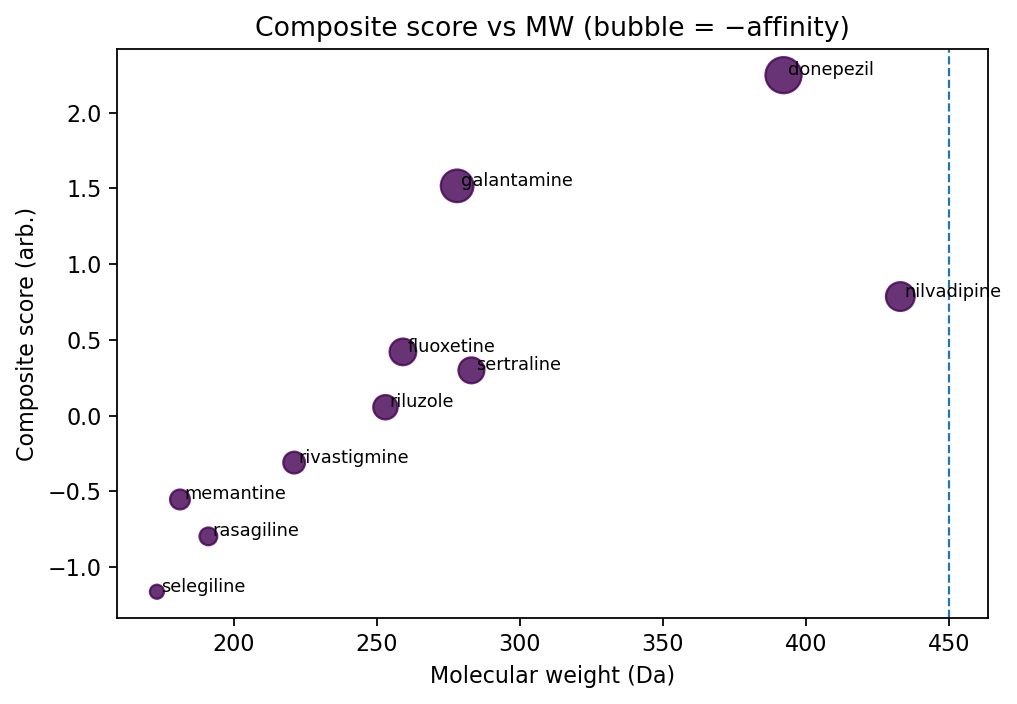

In [6]:
# Title: Figure 2 - Composite vs MW (bubble plot)
dfp = df_ranked.copy()
dfp["neg_aff"] = -dfp["affinity_kcal_mol"]  # larger bubble = stronger binding
sizes = 80 * (dfp["neg_aff"] - dfp["neg_aff"].min() + 0.5)  # scaled sizes

fig, ax = plt.subplots(figsize=(6.5,4.5))
sc = ax.scatter(dfp["MW"], dfp["composite_score"], s=sizes, c=dfp["BBB_pass"].map({True:1, False:0}), alpha=0.8)
for _, r in dfp.iterrows():
    ax.text(r["MW"]+1.5, r["composite_score"], r["ligand"], fontsize=8)

ax.axvline(450, ls="--", lw=1)  # simple MW guide
ax.set_xlabel("Molecular weight (Da)")
ax.set_ylabel("Composite score (arb.)")
ax.set_title("Composite score vs MW (bubble = −affinity)")
out = REPORTS / "fig2_composite_vs_mw.png"
plt.tight_layout()
plt.savefig(out, bbox_inches="tight")
out


WindowsPath('C:/Users/ashak/ad-quantum-repurpose/results/reports/fig3_bbb_space.png')

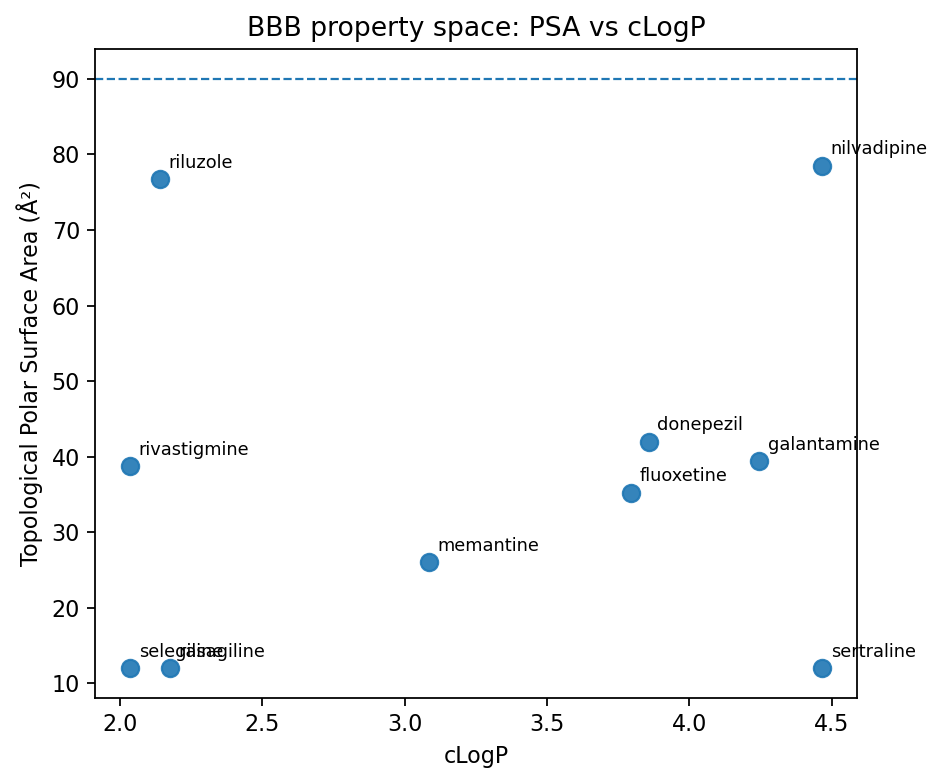

In [4]:
# Title: Figure 3 - BBB property space (PSA vs cLogP)
dfp = df_ranked.copy()

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(dfp["cLogP"], dfp["PSA"], s=60, alpha=0.9)
for _, r in dfp.iterrows():
    ax.text(r["cLogP"]+0.03, r["PSA"]+1.5, r["ligand"], fontsize=8)

# Simple guide-lines (illustrative)
ax.axhline(90, ls="--", lw=1)  # PSA threshold guide
ax.set_xlabel("cLogP")
ax.set_ylabel("Topological Polar Surface Area (Å²)")
ax.set_title("BBB property space: PSA vs cLogP")
out = REPORTS / "fig3_bbb_space.png"
plt.tight_layout()
plt.savefig(out, bbox_inches="tight")
out


In [5]:
# Title: Table 1 - Full ranking (CSV + Markdown)
tbl1 = df_ranked[["ligand","affinity_kcal_mol","MW","PSA","cLogP","BBB_pass","composite_score"]].copy()
tbl1.to_csv(REPORTS / "table1_ranking.csv", index=False)

# Markdown export
try:
    import tabulate
    md = tabulate.tabulate(tbl1, headers="keys", tablefmt="github", showindex=False)
    (REPORTS / "table1_ranking.md").write_text(md, encoding="utf-8")
except Exception:
    # fallback minimal
    (REPORTS / "table1_ranking.md").write_text(tbl1.to_string(index=False), encoding="utf-8")

(REPORTS / "table1_ranking.csv", REPORTS / "table1_ranking.md")


(WindowsPath('C:/Users/ashak/ad-quantum-repurpose/results/reports/table1_ranking.csv'),
 WindowsPath('C:/Users/ashak/ad-quantum-repurpose/results/reports/table1_ranking.md'))

In [6]:
# Title: Table 2 - Top5 + effect sizes (CSV + Markdown)
top5 = df_ranked.head(5)[["ligand","affinity_kcal_mol","BBB_pass","composite_score","MW","PSA","cLogP"]].copy()

# Effect sizes
vals = df_dock["affinity_kcal_mol"].sort_values().to_list()
best, worst = vals[0], vals[-1]         # best is most negative
median = np.median(vals)
effect_best_vs_worst = (abs(best) - abs(worst)) / abs(worst) * 100.0
effect_best_vs_median = (abs(best) - abs(median)) / abs(median) * 100.0

summary = pd.DataFrame({
    "metric": ["best_affinity","worst_affinity","median_affinity","improvement_%_best_vs_worst","improvement_%_best_vs_median"],
    "value": [best, worst, median, effect_best_vs_worst, effect_best_vs_median]
})

top5.to_csv(REPORTS / "table2_top5.csv", index=False)
summary.to_csv(REPORTS / "table2_effects.csv", index=False)

# Markdown exports
try:
    import tabulate
    md1 = tabulate.tabulate(top5, headers="keys", tablefmt="github", showindex=False)
    md2 = tabulate.tabulate(summary, headers="keys", tablefmt="github", showindex=False)
    (REPORTS / "table2_top5.md").write_text(md1, encoding="utf-8")
    (REPORTS / "table2_effects.md").write_text(md2, encoding="utf-8")
except Exception:
    (REPORTS / "table2_top5.md").write_text(top5.to_string(index=False), encoding="utf-8")
    (REPORTS / "table2_effects.md").write_text(summary.to_string(index=False), encoding="utf-8")

(REPORTS / "table2_top5.csv", REPORTS / "table2_effects.csv")


(WindowsPath('C:/Users/ashak/ad-quantum-repurpose/results/reports/table2_top5.csv'),
 WindowsPath('C:/Users/ashak/ad-quantum-repurpose/results/reports/table2_effects.csv'))

Saved: C:\Users\ashak\ad-quantum-repurpose\results\reports\fig2_lollipop_composite.png


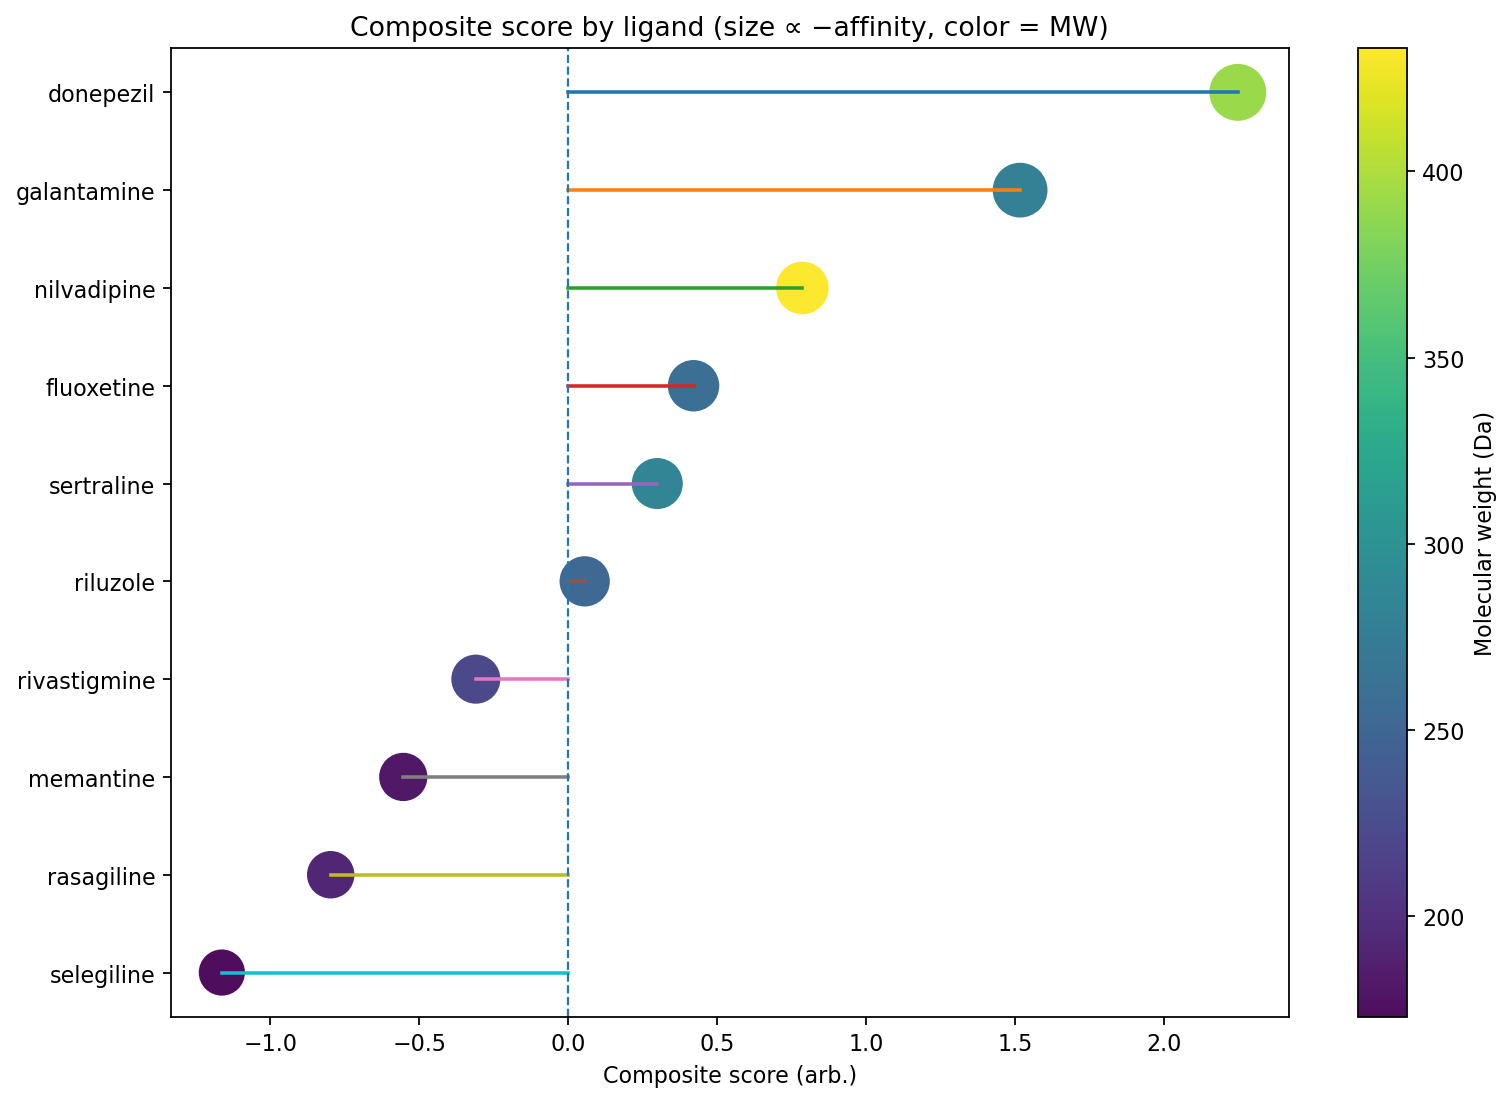

In [8]:
# FIGURE 2: Lollipop chart — one row per ligand, no text overlap
import numpy as np
import matplotlib.pyplot as plt

d2 = df_ranked.sort_values("composite_score", ascending=False).reset_index(drop=True)

y = np.arange(len(d2))                    # one clean lane per ligand
x = d2["composite_score"].to_numpy()
sizes = (-d2["affinity_kcal_mol"]).clip(lower=0).to_numpy() * 80  # bubble ∝ −affinity
mw = d2["MW"].to_numpy()                 # color by MW for extra info

plt.figure(figsize=(10, 7))
ax = plt.gca()

# stems from 0 to composite score
for yi, xi in zip(y, x):
    ax.plot([0, xi], [yi, yi], lw=1.6)

# endpoint bubbles
sc = ax.scatter(x, y, s=sizes, c=mw, cmap="viridis", alpha=0.95, edgecolor="none")

# cosmetics
ax.axvline(0, lw=1, ls="--")  # reference at 0
ax.set_yticks(y)
ax.set_yticklabels(d2["ligand"])
ax.invert_yaxis()             # best (largest) at top
ax.set_xlabel("Composite score (arb.)")
ax.set_title("Composite score by ligand (size ∝ −affinity, color = MW)")
cb = plt.colorbar(sc, ax=ax, label="Molecular weight (Da)")
plt.tight_layout()

out2 = REPORTS / "fig2_lollipop_composite.png"
plt.savefig(out2, dpi=300)
print("Saved:", out2)
plt.show()


Saved: C:\Users\ashak\ad-quantum-repurpose\results\reports\fig3_bbb_space_legend.png


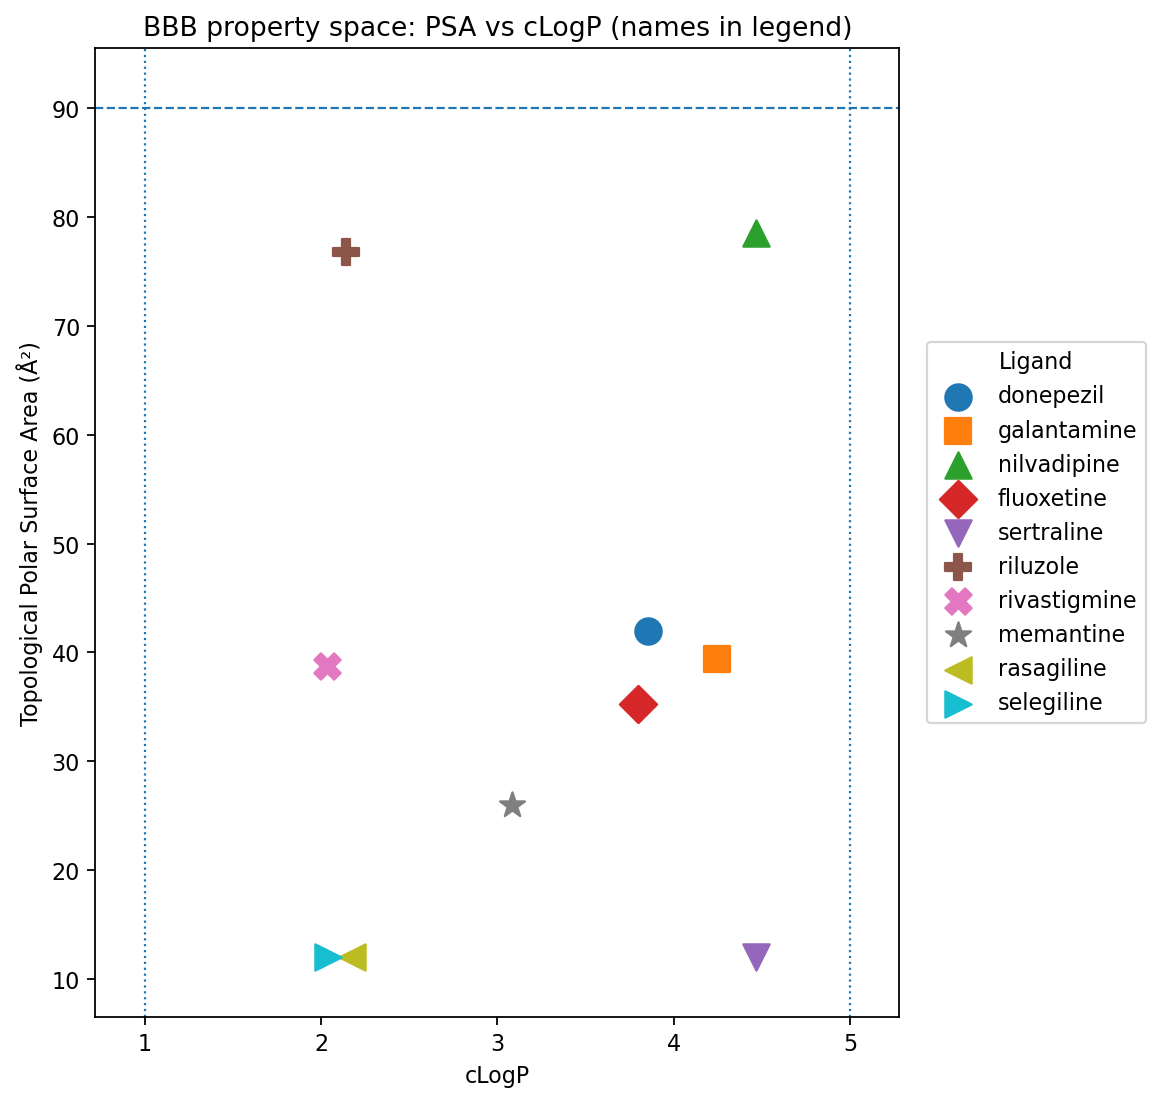

In [9]:
# FIGURE 3: Clean scatter — legend carries names, so no overlapping labels
import matplotlib.pyplot as plt

d3 = df_ranked.copy()

plt.figure(figsize=(9.5, 7))
ax = plt.gca()

# cycle distinct markers/colors for readability
markers = ["o", "s", "^", "D", "v", "P", "X", "*", "<", ">"]
for i, (_, row) in enumerate(d3.iterrows()):
    ax.scatter(row["cLogP"], row["PSA"], s=140, marker=markers[i % len(markers)], label=row["ligand"])

# BBB heuristics
ax.axhline(90, ls="--", lw=1)     # PSA ≤ 90 Å² often BBB-permissive
ax.axvline(1, ls=":", lw=1)       # typical cLogP window ~1–5
ax.axvline(5, ls=":", lw=1)

ax.set_xlabel("cLogP")
ax.set_ylabel("Topological Polar Surface Area (Å²)")
ax.set_title("BBB property space: PSA vs cLogP (names in legend)")
ax.margins(0.07)

# put legend outside to keep plot area clean
leg = ax.legend(title="Ligand", loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.78, 1])  # leave room for legend

out3 = REPORTS / "fig3_bbb_space_legend.png"
plt.savefig(out3, dpi=300)
print("Saved:", out3)
plt.show()
